<a href="https://colab.research.google.com/github/ohamed/StanceEval24/blob/main/Multi_Class_Classification_StanceEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FineTuning BERT for Multi-Class Classification with Mawqif dataset.

-

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install transformers datasets

In [3]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 49.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

This install might be enough!

In [4]:
#!pip install accelerate -U

In [5]:
import pandas as pd

In [6]:
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
ROOT_DIR = '/content/drive/MyDrive/Datasets/StanceEval24/' # If you have downloaded the data in local Machine

In [20]:
df= pd.read_csv(ROOT_DIR + "Mawqif.csv")
df.head()

,Unnamed: 0,ID,text,target,stance,sarcasm,sentiment
0,0,1,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند...,Women empowerment,Against,No,Negative
1,1,3,روح حلل محد يم تطعيم كورونا شف الحرم البارح مل...,Covid Vaccine,NaN,Yes,Neutral
2,2,4,يعرف بفوبيا المراه المتمكنه افه فكريه تغزو عقو...,Women empowerment,Favor,Yes,Negative
3,3,6,LEAP22 مءتمر يجمع اشهر وابرز المءثرين المجال ا...,Digital Transformation,Favor,No,Positive
4,4,7,خصوصيه البيانات وحمايتها المنظمه مطلب ينبغي ان...,Digital Transformation,Favor,No,Neutral


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3502 entries, 0 to 3501
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3502 non-null   int64 
 1   ID          3502 non-null   int64 
 2   text        3502 non-null   object
 3   target      3502 non-null   object
 4   stance      3169 non-null   object
 5   sarcasm     3502 non-null   object
 6   sentiment   3502 non-null   object
dtypes: int64(2), object(5)
memory usage: 191.6+ KB


In [18]:
df_org = df[["text", "stance"]]

In [19]:
#df_org = df_org.sample(frac=1.0, random_state=42)
df_org.head()

,text,stance
0,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند...,Against
1,روح حلل محد يم تطعيم كورونا شف الحرم البارح مل...,NaN
2,يعرف بفوبيا المراه المتمكنه افه فكريه تغزو عقو...,Favor
3,LEAP22 مءتمر يجمع اشهر وابرز المءثرين المجال ا...,Favor
4,خصوصيه البيانات وحمايتها المنظمه مطلب ينبغي ان...,Favor


In [12]:
df_org.shape # 3502 observations

(3502, 2)

- Take the Intent_en or Intent_ar from PAL/MSA train.

In [13]:
labels = df_org['stance'].unique().tolist()
#labels = [s.strip() for s in labels ]
labels

['Against', nan, 'Favor']


## Why we need id2label and labe2ids in NLP Projects

In NLP tasks, especially those involving classification problems, id2label and label2id dictionaries are used to map class labels (categories) to integer IDs and vice versa. These mappings are essential for various stages of the NLP pipeline, such as data preprocessing, model training, and evaluation.

**Data preprocessing**: In order to feed text data into an NLP model, the text must first be tokenized and then converted into numerical values. Similarly, class labels must also be transformed into numerical representations. The label2id dictionary helps in converting the original class labels into integer IDs.

**Model training**: NLP models usually output probability distributions over classes as their predictions. During training, the model's predictions are compared against the ground truth labels (which have been converted to integer IDs) to compute the loss and optimize the model parameters.

**Model evaluation and interpretation**: Once the model has been trained, its predictions (in the form of integer IDs) need to be mapped back to their original class labels to make the results interpretable. The id2label dictionary is used to perform this conversion.


For `BertForSequenceClassification` model as well I need these exact mapping of id2labels and labels2id in dictionary form.

### Hence, fefore you start training your model, create a map of the expected ids to their labels with id2label and label2id:

In [ ]:
for key, value in enumerate(labels):
    print(key, value)

0 Against
1 None
2 Favor


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
#len(labels)

In [ ]:
print(label2id, id2label)

{'Against': 0, 'None': 1, 'Favor': 2} {0: 'Against', 1: 'None', 2: 'Favor'}


In [ ]:
df_org.head()

,text,stance
0,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند...,Against
1,روح حلل محد يم تطعيم كورونا شف الحرم البارح مل...,None
2,يعرف بفوبيا المراه المتمكنه افه فكريه تغزو عقو...,Favor
3,LEAP22 مءتمر يجمع اشهر وابرز المءثرين المجال ا...,Favor
4,خصوصيه البيانات وحمايتها المنظمه مطلب ينبغي ان...,Favor


### Create a new column to represent the categories in numerical form

I need a 'label' column heading with numeric value else while running the epochs with `trainer.train()` I will get below error

```
BertForSequenceClassification ValueError: The model did not return

```


### In below I am doing it manually, but I could have also done it with pd.factorize() as below

Pandas factorize method is used for encoding categorical variables as integers. It assigns a unique integer value to each distinct category in a given Series or DataFrame, effectively transforming non-numeric data into numeric values.

In [ ]:
#df_org['labels_num'] = pd.factorize(df_org.category)[0]
#df_org.head()

In [ ]:
#df_org["labels"]= df_org["Intent_ID"] -1
df_org["labels"]= pd.factorize(df_org.stance)[0]
#df_org["labels"]= df_org.stance.map(lambda x: label2id[x.strip()]) #Intent_en

<ipython-input-22-0c81b20623f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org["labels"]= pd.factorize(df_org.stance)[0]


In [ ]:
df_org.tail(10)

,text,stance,labels
3492,ظل رءيه 2030 صناعه السياحه انتظرت اليوم ساعات ...,Favor,2
3493,تحديات للتحول الرقمي الموارد البشريه التحولالر...,None,1
3494,تمكين المراه يعني فتح المجال للعمل مجالات تناس...,Favor,2
3495,وحده الحسنات القليله كورونا لجوء الكثير المحلا...,Favor,2
3496,التحول النظام الورقي الي النظام الرقمي يعني اس...,Favor,2
3497,جماعه الخير انا اهلي حاشتنا كورونا خلصنا العام...,None,1
3498,للاسف مدراء الدواءر العقليات القديمه سبب تعثر ...,Favor,2
3499,عصر تمكين المراه وانما عصر تدمير الاسره والمجت...,Against,0
3500,ياجماعه الخير يعقل اليوم جهه خدميه تذهب لانجاز...,Favor,2
3501,التحول الالكتروني يقضي علي الفوضي ويرتقي بالمهنه,Favor,2


In [ ]:
the_labels = df_org['labels'].unique().tolist()
the_labels

[0, 1, 2]

In [ ]:
#df_org.category.value_counts().plot(kind='pie', figsize=(3,3))

<Axes: ylabel='stance'>

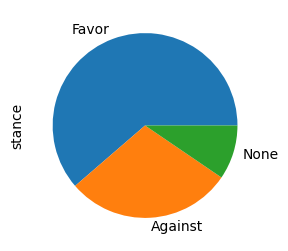

In [ ]:
df_org.stance.value_counts().plot(kind='pie', figsize=(3,3))

<Axes: >

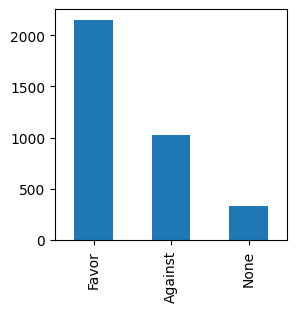

In [ ]:
df_org.stance.value_counts().plot(kind='bar', figsize=(3,3))

# The test of new model begins here.

In [ ]:
"""
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "asafaya/bert-base-arabic-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
"""

'\nfrom transformers import AutoModelForSequenceClassification, AutoTokenizer\nmodel_name = "asafaya/bert-base-arabic-sentiment"\ntokenizer = AutoTokenizer.from_pretrained(model_name)\nmodel = AutoModelForSequenceClassification.from_pretrained(model_name)\n'

In [22]:
model_name = "aubmindlab/bert-base-arabertv01"
#model_name = "aubmindlab/bert-base-arabertv02"
#model_name = "asafaya/bert-base-arabic-sentiment"

In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)
tokenizer = BertTokenizerFast.from_pretrained(model_name, max_length=128) #
#tokenizer = BertTokenizerFast.from_pretrained("asafaya/bert-base-arabic-sentiment", max_length=256)#

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### OH: To find the max-length in a df.

In [ ]:
# Function to tokenize text and calculate length
def get_max_length(row):
    #tokens = tokenizer(row['text'], return_tensors='pt')['input_ids'][0] #Note that text is the column name.
    tokens = tokenizer(row['text'], return_tensors='pt')['input_ids'][0]
    return len(tokens)

In [ ]:
# Apply the function to each row and find the maximum length
max_length = df_org.apply(get_max_length, axis=1).max()

print("Maximum length of sentences:", max_length)

Maximum length of sentences: 103


In [ ]:
print(max_length) # 103
mapping = {'None': 0, 'Favor': 1, 'Against': 2}

103


In [ ]:
mapping

{'None': 0, 'Favor': 1, 'Against': 2}

In [ ]:
df_org['labels'] = df['stance'].apply(lambda x: mapping[x])

<ipython-input-260-14c904a0f423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org['labels'] = df['stance'].apply(lambda x: mapping[x])


In [ ]:
df_org.head(1)

,text,stance,labels
0,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند والحكومه اكثر تقمع المراه اخر شيء الي فرحانين بالقرار ودارسين قانون متوظفين كاشير مول راتبهم 3 الاف,Against,2


In [ ]:
## Done
#model_name = "aubmindlab/bert-base-arabertv01"
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
#model.to(device)

In [ ]:
#print(asd)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Useful information and understanding you know about the model from the above output

**Model components:** The model consists of several key components, such as:

* Embeddings (word, position, and token type embeddings)

* Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

* Layer normalization and dropout layers for regularization

* GELU activation functions used in the intermediate layers

**Model dimensions:**

* Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

* Position embeddings: The model can handle input sequences of up to 512 tokens in length.

* Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

* Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

--------------------------

## Lets understand the flow of a raw input-text > through the pretrained BERT Model > and finally coming out on the other side of the model as a class prediction in the context of this task-specific fine-tuning.

In BERT-based models like BertForSequenceClassification, the [CLS] token (short for "classification") serves as a special token that is prepended to the input sequence. It is designed to be used as an aggregate representation of the entire input sequence for classification tasks.

Here's a step-by-step breakdown of how the [CLS] token is handled during fine-tuning for a specific classification task:

Tokenization: During the pre-processing of the input text, the tokenizer inserts the [CLS] token at the beginning of the input sequence. For example, if the input text is "This is a sample sentence.", the tokenized input would look like: "[CLS] This is a sample sentence."

**Embeddings:** The tokenized input sequence, including the [CLS] token, is passed through the BERT model's embedding layers, which convert the tokens into continuous-valued word vectors.

**Encoder layers:** The embedded input sequence is then processed through the BERT model's encoder layers, which consist of self-attention mechanisms and feed-forward neural networks. During this process, the model learns to capture the semantic and syntactic information present in the input sequence, as well as any relationships between the tokens.

**Final hidden state of [CLS]:** At the end of the BERT model's encoder layers, each token has a corresponding hidden state vector. For the [CLS] token, its final hidden state is used as an aggregated representation of the entire input sequence. This vector is then passed to the task-specific classification layer.

**Linear layer:** The final hidden state of the [CLS] token is fed into a linear layer, which maps the 768-dimensional vector (assuming the base BERT model) to a vector of size equal to the number of target classes. This is essentially a weight matrix multiplication followed by a bias term addition.

**Softmax function:** The output of the linear layer is then passed through a softmax function, which converts the raw output values into class probabilities. The softmax function ensures that the sum of probabilities across all classes equals 1.

**Prediction:** The class with the highest probability is chosen as the final prediction for the given input sequence.

During task-specific fine-tuning, the model learns to adjust its weights and biases based on the training data and the target labels. This involves updating both the BERT model's pre-trained parameters and the task-specific classification layer's parameters through backpropagation and optimization techniques like gradient descent. This fine-tuning process allows the model to adapt to the specific classification task and improve its performance on the given dataset.

-------------------

## In the above task specific fine tuning do all of the weights of the pretrained BERT model gets modified during this finetuning process or only some of the weights get modified ?


During task-specific fine-tuning, all of the weights of the pre-trained BERT model are potentially subject to modification, including the weights in the embedding layers, the encoder layers, and the classification layer. However, the extent to which each weight is modified depends on the learning rate, the specific task, and the training data.

In general, fine-tuning a pre-trained model like BERT involves updating its weights to better adapt to the target task. When fine-tuning begins, the initial weights of the model come from the pre-trained model, which has already learned general language representations from a large-scale unsupervised task (e.g., masked language modeling).

During fine-tuning, the model is exposed to the particular task-specific training data and labels, and the weights are updated using backpropagation and gradient descent.

Typically, the learning rate for fine-tuning is set to be smaller than the learning rate used during pre-training. This is because the pre-trained model already has a good understanding of language, and the fine-tuning process aims to make small, incremental adjustments to the weights to adapt the model to the specific task without losing the valuable general language knowledge.

## Splitting df_org


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into train, validation, and test sets
# TBD later, but for other cases!

"""
val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels, test_size=0.5, random_state=42)

train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(df_org['text'], df_org['labels'], test_size=0.25, random_state=42)
"""

## Feature
X = list(df_org.text)

##target
y = list(df_org.labels)

In [ ]:
# Split data into train and test sets (the rest train, 350 for test or 10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=350, random_state=42)

In [ ]:
# Split train data into train and validation sets (ca. 70% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
SIZE= df_org.shape[0] # 3502
SIZE

3502

In [ ]:
df_org.head(3)

,text,stance,labels
0,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند والحكومه اكثر تقمع المراه اخر شيء الي فرحانين بالقرار ودارسين قانون متوظفين كاشير مول راتبهم 3 الاف,Against,2
1,روح حلل محد يم تطعيم كورونا شف الحرم البارح مليونين بدون شرط تحصين😅,None,0
2,يعرف بفوبيا المراه المتمكنه افه فكريه تغزو عقول الرجال انه اذ راي تمكين للمراه حتي بسيطا فهو المرجح بالطبع ربطه للموضوع النسويه واتهام الفكره باكملها بالشيطنه والخبث URL,Favor,1


In [ ]:
"""
train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])
"""

In [ ]:
len(X_train), len(X_val), len(X_test)

(2016, 505, 350)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings  = tokenizer(X_val, truncation=True, padding=True) #val_texts_new
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


## From above DataLoader() The line `item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}`

Here I use a dictionary comprehension that constructs a new dictionary called `item`. This line converts the encoding values associated with the input text at the given index idx into PyTorch tensors.

self.encodings is a dictionary containing tokenized input text with keys like 'input_ids', 'token_type_ids', and 'attention_mask'. These keys represent different aspects of the encoded text that are needed for processing by the BERT model. The values associated with these keys are lists or arrays of integers.

.items() is a method that returns a view object displaying a list of a dictionary's key-value pairs as tuples.

The dictionary comprehension iterates through the key-value pairs of self.encodings with the variables key and val. For each key-value pair, it creates a new key-value pair in the item dictionary, where the key remains the same, and the value is a PyTorch tensor created from the elements at index idx of the original value.

In essence, this line of code is converting the relevant parts of the input encodings (e.g., input IDs, attention masks) at the given index idx into PyTorch tensors and storing them in a new dictionary called item. This format is necessary for input to the BERT model during training or evaluation.

Here's an example of the output format for self.encodings:


```
{
    'input_ids': [
        [101, 2023, 2003, 1037, 2742, 102],
        [101, 1045, 2066, 5009, 2102, 102],
        [101, 2129, 2024, 2017, 1029, 102]
    ],
    'token_type_ids': [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ],
    'attention_mask': [
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]
    ]
}
```

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

* input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

* token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

* attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

Note that this example assumes that the maximum sequence length is 6 tokens, and there's no need for padding or truncation. In practice, you would have longer sequences, and padding would be necessary to make all the input sequences have the same length.

In [ ]:
train_dataloader = DataLoader(train_encodings, y_train)#train_labels

val_dataloader = DataLoader(val_encodings, y_val) #val_labels

test_dataset = DataLoader(test_encodings, y_test)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    #fp16=True, ## with GPUs only
    load_best_model_at_end=True
)

In [ ]:
!nvidia-smi #GPU Info

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
"""
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print(torch.cuda.is_available()) # True
print(torch.version.cuda) # 12.1
"""

"\nimport os\nos.environ['CUDA_LAUNCH_BLOCKING'] = '1'\n"

In [ ]:
#df_org.info()

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.946500,0.737013,0.669307,0.397386,0.771769,0.412701
100,0.712800,0.687902,0.738614,0.502373,0.807770,0.537583
150,0.703200,0.735069,0.734653,0.499375,0.805243,0.532953
200,0.635000,0.658409,0.728713,0.524139,0.550165,0.524048
250,0.614500,0.622419,0.734653,0.555308,0.570057,0.571879
300,0.502200,0.672650,0.720792,0.540895,0.598369,0.568443
350,0.417100,0.672125,0.756436,0.579072,0.637167,0.577054


TrainOutput(global_step=378, training_loss=0.634005309412719, metrics={'train_runtime': 1612.7903, 'train_samples_per_second': 3.75, 'train_steps_per_second': 0.234, 'total_flos': 261074288740608.0, 'train_loss': 0.634005309412719, 'epoch': 3.0})

In [ ]:
#print(asd)

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

In [ ]:
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.343620,0.882440,0.749337,0.881758,0.727541
val,0.660448,0.752475,0.575563,0.625947,0.573678
test,0.583618,0.788571,0.629468,0.799437,0.620134


In [ ]:
#pd.DataFrame(q, index=["train","val","test"]).iloc[:,-5:]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    #inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to("cuda") ## remove .to("cuda") with CPU
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt") ## with CPU

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Adjust display options
pd.set_option('display.max_colwidth', None)  # Show full column width
#pd.set_option('display.max_rows', None)       # Show all rows

In [ ]:
df_org.head(20)

,text,stance,labels
0,عشان يلمع صورته ويعنني تمكين المراه ويصير ترند والحكومه اكثر تقمع المراه اخر شيء الي فرحانين بالقرار ودارسين قانون متوظفين كاشير مول راتبهم 3 الاف,Against,2
1,روح حلل محد يم تطعيم كورونا شف الحرم البارح مليونين بدون شرط تحصين😅,None,0
2,يعرف بفوبيا المراه المتمكنه افه فكريه تغزو عقول الرجال انه اذ راي تمكين للمراه حتي بسيطا فهو المرجح بالطبع ربطه للموضوع النسويه واتهام الفكره باكملها بالشيطنه والخبث URL,Favor,1
3,LEAP22 مءتمر يجمع اشهر وابرز المءثرين المجال التقني خلاله السعوديه تستعرض قدرتها التحول الرقمي اللي تشهدها كافه قطاعاتها 👌🏼 URL,Favor,1
4,خصوصيه البيانات وحمايتها المنظمه مطلب ينبغي ان تكون ذريعه لسد الطريق امام التحول التقني لاننا نجهل نحمي بياناتنا الفضاء التقني ان عمليه التحول الرقمي خيارا نقبله او نرفضه ونحن قطاع يتسم بالشفافيه والمشاركه المجتمع واصحاب المصلحه,Favor,1
5,فخورين بنساء الوطن 🇸🇦 وكلنا فخر بتقدم تمكين المراه يوم يوم الله يديم حكومتنا ويحفظ بلادنا ويعزها 🤍,Favor,1
6,ههههههههههههههه ماعليك زمن تمكين المراه ماراح يسوون شي 😂,None,0
7,كعاده البشر ذوي العقليات المحدوده والكسوله الكل هاجمه وانتقده ووصفوه بالجنون والغباء وووو الخ سالفه التحول الرقمي والدفع الالكتروني المصيبه ان كلامه طلع صح ونجح,Favor,1
8,MENTION MENTION MENTION وش فاءده اللقاح انه تم تطعيم ٥٠ بالميه السكان والاصابات يوم تزيد وش الفايده يقول مايمنع الاصابه يخففها كورونا الاصل الشفاء وصل ٩٩ بالميه يعني اللقاح يعطينا ١٠٠ بالميه كلنا نسمع ونعرف ناس انصابوا وهم اخذين اللقاح ونقلوا العدوي لمجموعه,Against,2
9,يتمعن يجري اليوم الاوساط العلميه البحثيه علي الاصعده اهتمام مستميت بالتحول الواقع الي الافتراض التحول الرقمي الالكتروني واحلال الالات وتقنيات الذكاء الصناعي سيعلم كورونا ولماذا تم غلق العالم انتقاءيا وتعطيل الاقتصادالخ URL,Against,2


In [ ]:
# Test with a an example text in Turkish
#text = "Makine öğrenimi kendisi de daha da otomatik hale doğru ilerliyor."
text = "فخورين بنساء الوطن 🇸🇦 وكلنا فخر بتقدم تمكين المراه يوم يوم الله يديم حكومتنا ويحفظ بلادنا ويعزها" ## Against
#text= "عشان مره ماتصير هطف وتصدق وزاره الكحه ونصيحه تاخذ الجرعه الثالثه التنشيطيه لانها اللي تعيد تدوير اللقاح" #Against

# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0026, 0.9914, 0.0060]], grad_fn=<SoftmaxBackward0>),
 tensor(1),
 'None')

In [ ]:
text0 = 'ومافي امراه تبربر دخل الرجال وفلوسه زمن تمكين المراه الا عاجزه وارفله'
predict(text0)

(tensor([[0.1243, 0.1313, 0.7445]], grad_fn=<SoftmaxBackward0>),
 tensor(2),
 'Favor')

In [ ]:
text1 ='التحول الالكتروني يقضي علي الفوضي ويرتقي بالمهنه' ## Favor
predict(text1)

(tensor([[0.1389, 0.6373, 0.2237]], grad_fn=<SoftmaxBackward0>),
 tensor(1),
 'None')

In [ ]:
text2='تمكين المراه مكتسح 🤍🇸🇦' ## Favor
predict(text2)

(tensor([[0.0961, 0.0837, 0.8202]], grad_fn=<SoftmaxBackward0>),
 tensor(2),
 'Favor')

## Save model for inference

In [ ]:
model_path = "arabic-text-stanceEval"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('arabic-text-stanceEval/tokenizer_config.json',
 'arabic-text-stanceEval/special_tokens_map.json',
 'arabic-text-stanceEval/vocab.txt',
 'arabic-text-stanceEval/added_tokens.json',
 'arabic-text-stanceEval/tokenizer.json')

## Re-Load saved model for inference

In [ ]:
model_path = "arabic-text-stanceEval"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)

#nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [ ]:
#nlp("Bugün hava çok güzel, dışarıda yürümek istiyorum.")
nlp('الحمدالله علي نعمه ابشر ونعمه التحول الالكتروني') ## Favor
# Today the weather is very nice, I want to go for a walk outside

# Gives below output
#[{'label': 'saglik', 'score': 0.8295329213142395}]
# "Saglik" is a Turkish word that means "health" in English.

[{'label': 'None', 'score': 0.9456400275230408}]

In [ ]:
#nlp("Derin Öğrenme ve Yapay Zeka dünyayı değiştirecek.")
nlp("نقصد بالتويته ان الرجل مش نسوي لانه يتم اضطهاد...")
# Deep Learning and AI is going to change the world

# gives below output
#[{'label': 'teknoloji', 'score': 0.9932782053947449}]

[{'label': 'Favor', 'score': 0.5550872683525085}]

In [ ]:
nlp("امي اخذت تطعيم كورونا اليوم 👍🏻") ##Favor
# Due to recent volatility in the economy, the stock market index has been at quite low levels

#gives below output
#[{'label': 'ekonomi', 'score': 0.9850727915763855}]

[{'label': 'Against', 'score': 0.49603942036628723}]

In [ ]:
df_org.sample(25)

,text,stance
2110,MENTION MENTION مافيه تطعيم بالعالم يحمي ١٠٠٪ يقوله مسلم شي بامر الله كورونا وكل التطعيمات تعطيك حمايه بنسبه كبيره وتقلل نسبه المخاطر والاصابه كفيل اننا نتجه للتطعيم وتفعل بالاسباب انا طعمت بالانلفونزا واصابني خفيفه العبره احارب التطعيم واقول كذب,Favor
1920,تجار المخدرات الحقيقيين العالم ام انهم يعلمون وكالعاده يمارسون الدجل عبر الاعلام والذباب الالكتروني سارعب الانظمه بامتداح جيوشها بزعم انها منعت بلادها التحول صوب النموذج الطالباني 9,Favor
1039,خل كورونا تمر عليها الفيروسات تتشهد قال تطعيم قال 😅,Against
2537,اختفت الكتب والكتابه وهي تحدث بحكم التكنلوجيا واجهزتها الي يوم جديد ستعود الامه اجهل ماقبل التعليم لان عقولهم ستصبح بشريه لتوحد الفكر بعلم الالكتروني ستنغلق التدبر والتفكير ماحولها وستفقد الاجيال حيويه العقل البشري,Against
507,نتمني ظل التحول التقني والرقمي تشهده مملكتنا الحبيبه ظل قيادتنا الرشيده,Favor
966,ترا والله احنا نعاني حتي نكتب تغريده اي شي ينطون الربع🙈 تغريده فخر تمكين المراه بو محمد ليش زعلان😜,Favor
495,ماذ الاطفال اعمار اقل ١٥ عام عندهم زياره ولم يتلقو تطعيم كورونا اجراءات العمره نرجو الاجابه بارك الله فيكم,None
2856,حاليا ام سي ١ برنامج معاليالمواطن التحول الالكتروني التعليم والتعليم تجربه المملكه اكثر راءعه ناجحه,Favor
1674,انا مش مءمن بنظريات المءامره الي تحوم علي تطعيم كورونا الوقت نبيش نطعم تطعيم اعراض جانبيه كانت العشر الاف تبقي نسبه والاصابه بكورونا نسبه قليله تتدهور حالته الحالتين بعضهن اخذ التطعيم او اصبت بكورونا بدون تطعيم وانا اخترت نعتمد علي مناعتي,Against
696,ده جزء حمله رسميه للحد النسل بالكذب علي الذقونالطلاق سببه القوانين الفاسده والحملات الاعلاميه الفاجره تتكلم تمكين المراه والظلم الواقع عليهاوعيشي حياتك,Against


In [ ]:
nlp("نبي تمكين المراه بالبلديه URL") ## Favor

[{'label': 'Against', 'score': 0.5249345302581787}]

In [ ]:
nlp("نعودبحذر تطعيمكورونا ياجماعه الخير روحوا تطعموا طلبناكم تطعموا") #Favor

[{'label': 'None', 'score': 0.6431834101676941}]

In [ ]:
nlp("عرف وين يمسكهم يشوف الجدل وين ويشتغل شاف جدلهم علي تمكين المراه وحجابها وشد حيله باقي شوي ويلبس عبايه راس وقفاز عشان ينال اعجابهم ورضاهم	") #against

[{'label': 'Favor', 'score': 0.8116874694824219}]

In [ ]:
nlp('نتاج الانظمه الداعمه لحقوق المراه تمكين المراه هههههههه عقبال المسترجلات 🎸🎸💞') #Against

[{'label': 'Favor', 'score': 0.7112591862678528}]

In [ ]:
nlp('التحول الرقمي معظم المجالات مءسسات الدوله القطاع الخاص تصبح الحاجه ملحه لحمايه الانظمه عبث العابثين خلال الهجمات الالكترونيه تفوق اضرارها الهجوم التقليدي مركزالدفاعالالكتروني URL	')#none

[{'label': 'Favor', 'score': 0.42662230134010315}]

In [ ]:
nlp('تمكينالمراه وجهه نظر الديناصورات')

[{'label': 'Favor', 'score': 0.6991076469421387}]

In [ ]:
nlp('صحيح كورونا مسرع للتحول الرقمي التحول الرقمي السريع بدون اساس رصين بييسقط محاله مثال التعلم الالكتروني المدارس استطاع انه يشمل الطلبه الكثير الناس عندهم كمبيوترات او انترنت منزلي وايضا اصلا مش')

[{'label': 'Favor', 'score': 0.4192100763320923}]

In [ ]:
nlp('العالم كله رايح او بمعني اصح وهيبقي كله رقمي وسايبين حاجات كتيير اهم اصلا مكونات الحياه هيكتشفوها يثبت فشل التحول الرقمي')

[{'label': 'Favor', 'score': 0.669101893901825}]

In [ ]:
result1 = nlp('عرف وين يمسكهم يشوف الجدل وين ويشتغل شاف جدلهم علي تمكين المراه وحجابها وشد حيله باقي شوي ويلبس عبايه راس وقفاز عشان ينال اعجابهم ورضاهم')#against

In [ ]:
len(X_test), result1[0]

(350, {'label': 'Favor', 'score': 0.8116874694824219})

In [ ]:
predicted_labels = []

# Apply the model to each text
for text in X_test:
    # Apply the model to the text
    result = nlp(text)

    # Extract the predicted label
    predicted_label = result[0]['label']

    # Append the predicted label to the list
    predicted_labels.append(predicted_label)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#mapping = {0: 'Against', 1: 'None', 2: 'Favor'}
#mapping = {'None': 0, 'Favor': 1, 'Against': 2}

#mappingL2Id = {'None': 0, 'Favor': 1, 'Against': 2}

mappingIdL = {0: 'None', 1: 'Favor', 2: 'Against'}

In [ ]:
gold_labels = [mappingIdL[val] for val in y_test]

In [ ]:
gold_labels[0]

'Favor'

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(gold_labels, predicted_labels)

# Calculate precision
precision = precision_score(gold_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(gold_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(gold_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(gold_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.2714285714285714
Precision: 0.3282840722495895
Recall: 0.2714285714285714
F1-score: 0.27064295691891527
Confusion Matrix:
[[  7  88  13]
 [ 16  71 118]
 [  5  15  17]]
